In [2]:
## free path, what are regimes for plasma?
## what is precision of this method?
## sweeping frequency dependence?

#A&B tempereture
import numpy as np
import pandas as pd
import scipy as sp

import matplotlib
import matplotlib.pyplot as plt
import os

import datetime 

In [26]:
#load data using pandas
filename = 'Langmuir_results__1st.csv'
directory = './'
data = pd.read_csv(os.path.join(directory, filename), encoding='ISO-8859–1')

#Handling of data format from csv file
voltage = np.array( [float(v.replace(',', '.')) for v in data['Voltage[V]'].values])
current = np.array( [float(i.replace(',', '.')) for i in data['Current[ÂµA]'].values])
pressure = np.array( [float(p.replace(',', '.')) for p in data['Pressure[Pa]'].values])
time_string = data['Hora'].values
time_seconds = [datetime.datetime.strptime(t, "%Y-%m-%d %H:%M:%S.%f").timestamp() for t in time_string]
time_start = time_seconds[0]

#normalize time to 0
time_s = [t - time_start for t in time_seconds]

#print(time_s)

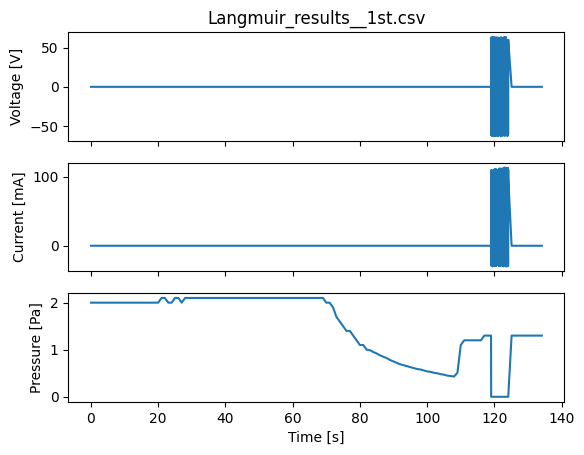

In [23]:
#show raw data from files
#TODO: Optimalization of data, convert to np arrays

fig, ax = plt.subplots(3, sharex=True)
ax[0].plot(time_s, voltage)
ax[1].plot(time_s, current)
ax[2].plot(time_s, pressure)
ax[0].set_title(filename)
ax[0].set_ylabel('Voltage [V]')
ax[1].set_ylabel('Current [mA]')
ax[2].set_ylabel('Pressure [Pa]')
ax[2].set_xlabel('Time [s]')

plt.show()

In [27]:
#select time window
time_a = 122.0
time_b = 124.0
num = 0
iter = 0
#Count amount of data
for v, i, p, t in zip(voltage, current, pressure, time_s):
    if time_a < float(t) < time_b:
        num += 1

#Create data vectors:
V = np.zeros(num)
I = np.zeros(num)
P = np.zeros(num)
T = np.zeros(num)

for v, i, p, t in zip(voltage, current, pressure, time_s):
    if time_a < float(t) < time_b:
        V[iter] = float(v)
        I[iter] = float(i)
        P[iter] = float(p)
        T[iter] = float(t)
        iter += 1
    if iter == num:
        break

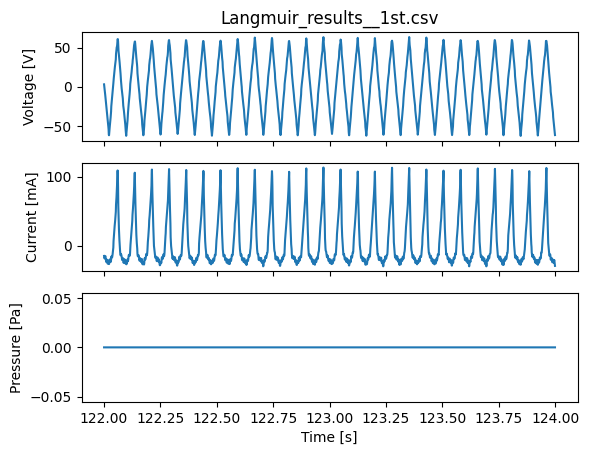

In [28]:
#plot of selected data:
fig, ax = plt.subplots(3, sharex=True)
ax[0].plot(T, V)
ax[1].plot(T, I)
ax[2].plot(T, P)
ax[0].set_title(filename)
ax[0].set_ylabel('Voltage [V]')
ax[1].set_ylabel('Current [mA]')
ax[2].set_ylabel('Pressure [Pa]')
ax[2].set_xlabel('Time [s]')

plt.show()

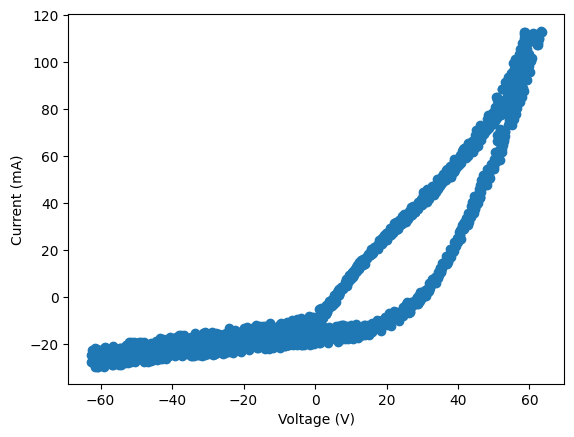

In [35]:

#Take log for analysis, not used in final code
V_log = np.log(V + 100) 
I_log = np.log(I + 40)

#plt.plot(V_log, I_log, 'o')
plt.plot(V, I, 'o')
plt.xlabel('Voltage (V)')
plt.ylabel('Current (mA)')

plt.show()

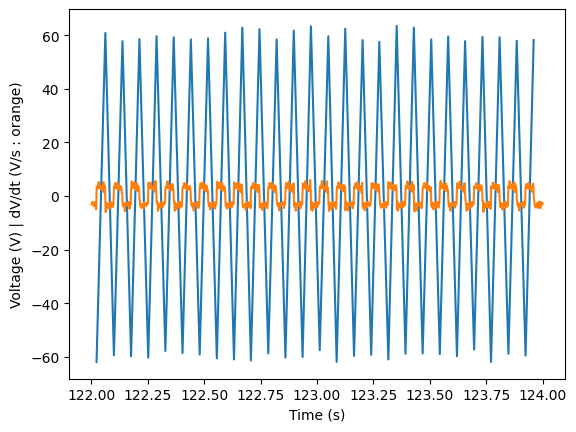

In [36]:
#Separation of raising and falling edge of sweep voltage based on gradient

dV_dt = np.gradient(V)

trigger = 1 # value of grad to triger detection

#Thanks for some guys from stackoverflow
mask1 = (dV_dt[:-1] < trigger) & (dV_dt[1:] > trigger)
mask2 = (dV_dt[:-1] > trigger) & (dV_dt[1:] < trigger)

edges_V = np.flatnonzero(mask1 | mask2) + 1

plt.plot(T[edges_V], V[edges_V])

plt.plot(T,dV_dt)
plt.ylabel('Voltage (V) | dV/dt (V/s : orange)')
plt.xlabel('Time (s)')

plt.show()

Detected edges: 53


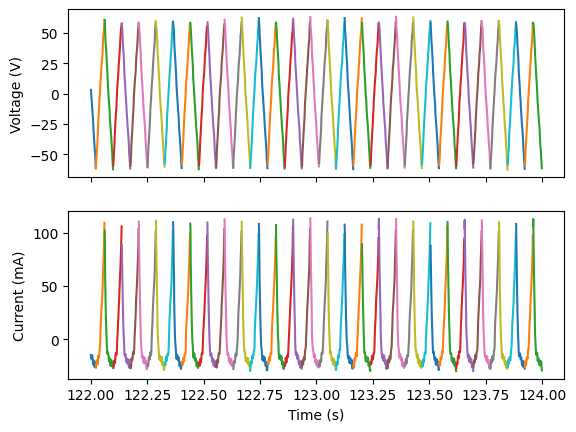

In [9]:
#Spliting data into arrays corresponding to separate edges
splited_V = np.split(V, edges_V)
splited_I = np.split(I, edges_V)
splited_T = np.split(T, edges_V)

num_edges = len(splited_V)
print('Detected edges: ' + str(num_edges))

fig, ax = plt.subplots(2, sharex=True)

#Show data:
for i in range(num_edges):
    ax[0].plot(splited_T[i], splited_V[i])
    ax[1].plot(splited_T[i], splited_I[i])
    
ax[0].set_ylabel('Voltage (V)')
ax[1].set_ylabel('Current (mA)')
ax[1].set_xlabel('Time (s)')
plt.show()

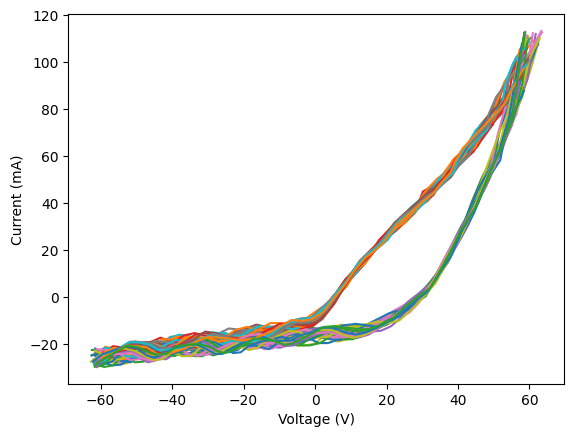

In [10]:
#Show all characteristics:
for i in range(num_edges):
    plt.plot(splited_V[i], splited_I[i])
plt.xlabel('Voltage (V)')
plt.ylabel('Current (mA)')
plt.show()

Positive edge data size: 1031
Negative edge data size: 968
All data size: 1999


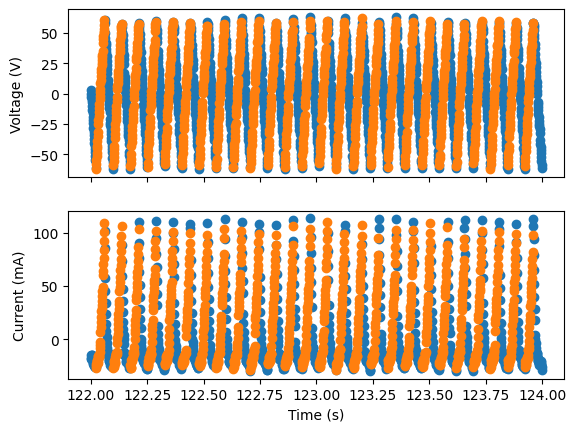

In [11]:
#Making mean statistics for analysis, separating raising edges from falling edges.
#TODO:
# Distinguish falling edge from raising, program only assumes that are two types of edges.
# Type 1 and type 2 correspond to these types. Use for that gradient value. 
# Noise filtering (FFT), cut-of high frequncy noise, or use different technique

type1_V_num = 0
type2_V_num = 0

for i in range(num_edges):
    if i % 2 == 0:
        type1_V_num += splited_V[i].size
    else:
        type2_V_num += splited_V[i].size

print('Positive edge data size: ' + str(type1_V_num))
print('Negative edge data size: ' + str(type2_V_num))
print('All data size: ' + str(V.size))

all_type1_V = np.zeros(type1_V_num)
all_type1_I = np.zeros(type1_V_num)
all_type1_T = np.zeros(type1_V_num)

all_type2_V = np.zeros(type2_V_num)
all_type2_I = np.zeros(type2_V_num)
all_type2_T = np.zeros(type2_V_num)

type1_iter = 0
type2_iter = 0

for i in range(num_edges):
    if i % 2 == 0:
        for j in range(splited_V[i].size):
            all_type1_V[type1_iter] = splited_V[i][j]
            all_type1_I[type1_iter] = splited_I[i][j]
            all_type1_T[type1_iter] = splited_T[i][j]
            type1_iter += 1
    else:
        for j in range(splited_V[i].size):
            all_type2_V[type2_iter] = splited_V[i][j]
            all_type2_I[type2_iter] = splited_I[i][j]
            all_type2_T[type2_iter] = splited_T[i][j]
            type2_iter += 1


fig, ax = plt.subplots(2, sharex=True)

#Show data:
ax[0].plot(all_type1_T, all_type1_V, 'o')
ax[0].plot(all_type2_T, all_type2_V, 'o')
ax[1].plot(all_type1_T, all_type1_I, 'o')
ax[1].plot(all_type2_T, all_type2_I, 'o')
    
ax[0].set_ylabel('Voltage (V)')
ax[1].set_ylabel('Current (mA)')
ax[1].set_xlabel('Time (s)')
plt.show()


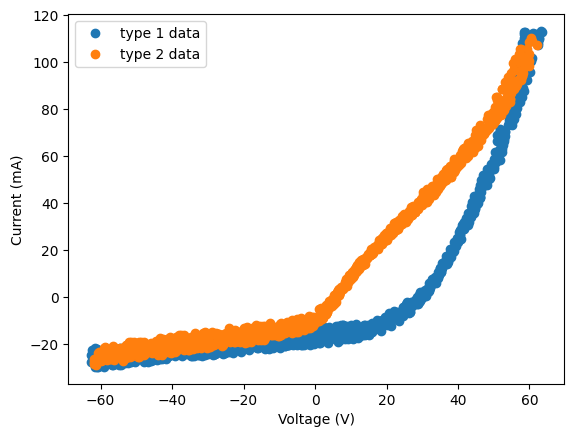

In [12]:
#Show characteristics:
plt.plot(all_type1_V, all_type1_I, 'o', label='type 1 data')
plt.plot(all_type2_V, all_type2_I, 'o', label='type 2 data')
plt.xlabel('Voltage (V)')
plt.ylabel('Current (mA)')
plt.legend()
plt.show()

Temperature: 6.454499774934321 eV
Ion current: 29.142684928856198 mA
Second temperature: 5.453999295228346 eV
Second current: 6.275490814725445 mA


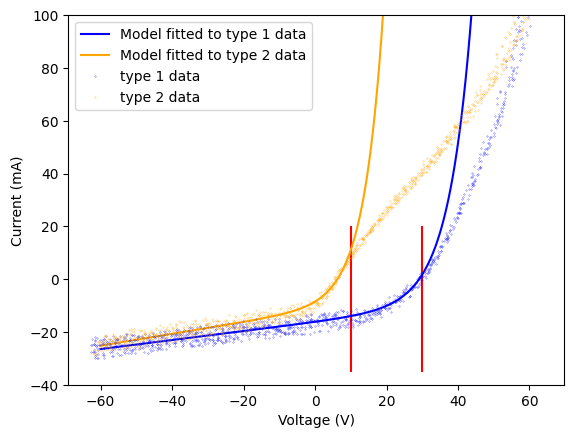

In [17]:
#Define ion current function
from scipy.optimize import curve_fit

e_k = 1 # no need for scipy constants
#print(e_k)

def current_model(Vs, Vf, Isat, alpha, temperature):
    return -Isat * ( 1 - alpha * (Vs - Vf) - np.exp( e_k* (Vs - Vf) / temperature))

#preparing data 
#cut-off for voltage taken to analysis
max_voltage_type1 = 30
max_voltage_type2 = 10

type1_num = 0
type2_num = 0

for v in np.sort(all_type1_V):
    if v < max_voltage_type1:
        type1_num += 1
for v in np.sort(all_type2_V):
    if v < max_voltage_type2:
        type2_num += 1

sorted_type1_V = np.sort(all_type1_V)[0:type1_num]
sorted_type1_I = np.sort(all_type1_I)[0:type1_num]
sorted_type2_V = np.sort(all_type2_V)[0:type2_num]
sorted_type2_I = np.sort(all_type2_I)[0:type2_num]

#Guess:
parameters = (0, 20, 0.01, 36)

#Type one fitting:
popt, pcov = curve_fit(current_model, sorted_type1_V, sorted_type1_I, p0=parameters)

#popt = parameters
v_values = np.linspace(-60, 60, num=1000)
i_values = np.array( [current_model(v, popt[0], popt[1], popt[2], popt[3]) for v in v_values] )

print('Temperature: ' + str(popt[3]) + ' eV')
print('Ion current: ' + str(popt[0]) + ' mA')

#Type two fitting:
popt2, pcov2 = curve_fit(current_model, sorted_type2_V, sorted_type2_I, p0=parameters)

#popt = parameters
v_values2 = np.linspace(-60, 60, num=1000)
i_values2 = np.array( [current_model(v, popt2[0], popt2[1], popt2[2], popt2[3]) for v in v_values] )

print('Second temperature: ' + str(popt2[3]) + ' eV')
print('Second current: ' + str(popt2[0]) + ' mA')

plt.plot(v_values, i_values, color='blue', label='Model fitted to type 1 data')
plt.plot(v_values2, i_values2, color='orange', label='Model fitted to type 2 data')
plt.plot(all_type1_V, all_type1_I, 'o', markersize=0.2, color='blue', label='type 1 data')
plt.plot(all_type2_V, all_type2_I, 'o', markersize=0.2, color='orange', label='type 2 data')

#Show cuts for model fitting
plt.vlines(sorted_type1_V[-1], -35, 20, colors='red')
plt.vlines(sorted_type2_V[-1], -35, 20, colors='red')


plt.ylim(-40, 100)
plt.legend()
plt.xlabel('Voltage (V)')
plt.ylabel('Current (mA)')

plt.show()

In [16]:
#Mean plasma temperature and sound speed

Temp_mean = (popt[3] + popt2[3])/2
argon_mass = 39.95 * 931493614.838934 # eV / u atomic mass
speed_of_light = 3 * 1e8 # m/s
plasma_speed = np.sqrt(Temp_mean / argon_mass) * speed_of_light 
print('Plasma speed: ' + str(plasma_speed))

Plasma speed: 3794.778553609473
